In [1]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from IPython import display
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
data_dir = tf.keras.utils.get_file('mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')
data_dir = pathlib.Path('data/mini_speech_commands')

182083584/182082353 [==============================] - 2s 0us/step


In [3]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('訓練類別:', commands)

訓練類別: ['left' 'yes' 'no' 'stop' 'down' 'right' 'go' 'up']


In [4]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print('訓練資料集大小', len(train_files))
print('驗證資料集大小', len(val_files))
print('測試資料集大小', len(test_files))
print('檔案範例：', filenames[0])

訓練資料集大小 6400
驗證資料集大小 800
測試資料集大小 800
檔案範例： tf.Tensor(b'data/mini_speech_commands/right/d91a159e_nohash_0.wav', shape=(), dtype=string)


#讀取聲音檔案與標記

In [5]:
#編碼
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

In [6]:
#設定標籤
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  return parts[-2]

In [7]:
#整合音檔與標籤
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

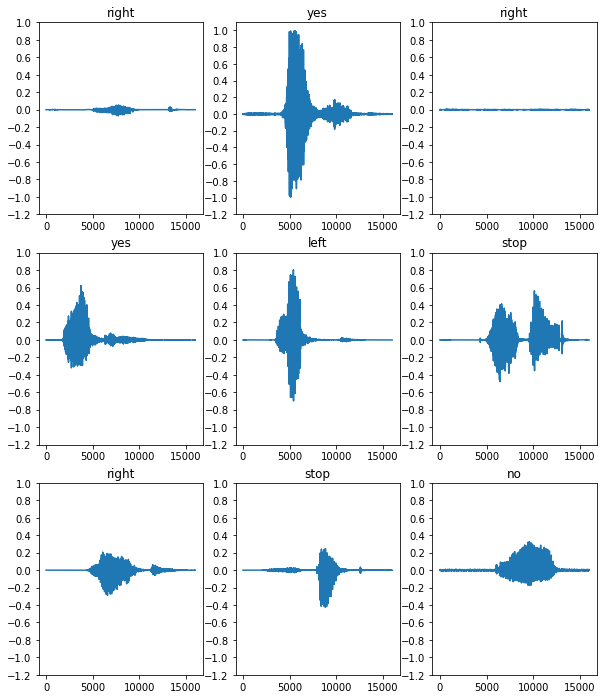

In [9]:
#觀察每一個訓練資料與標籤的內容
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [10]:
#將資料轉為時頻圖
def get_spectrogram(waveform):
  # 填充資料到16000，原始的音檔的x軸也是16000
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

  # 連結audio與zero_padding
  # 輸入單一檔案觀察
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)

  spectrogram = tf.abs(spectrogram)

  return spectrogram


In [11]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('標籤:', label)
print('波形圖的維度:', waveform.shape)
print('時頻圖的維度:', spectrogram.shape)
print('音檔播放器')
display.display(display.Audio(waveform, rate=16000))

標籤: right
波形圖的維度: (16000,)
時頻圖的維度: (124, 129)
音檔播放器


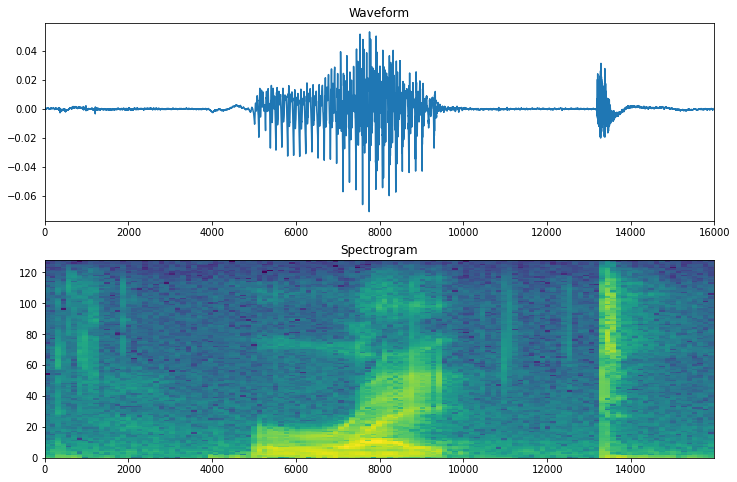

In [12]:
#建立時頻圖
def plot_spectrogram(spectrogram, ax):
  # 時頻圖轉換
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  X = np.arange(16000, step=height + 1)
  Y = range(height)
  #pcolormesh繪製時頻圖
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [13]:
#獲取資料與標籤
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [14]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

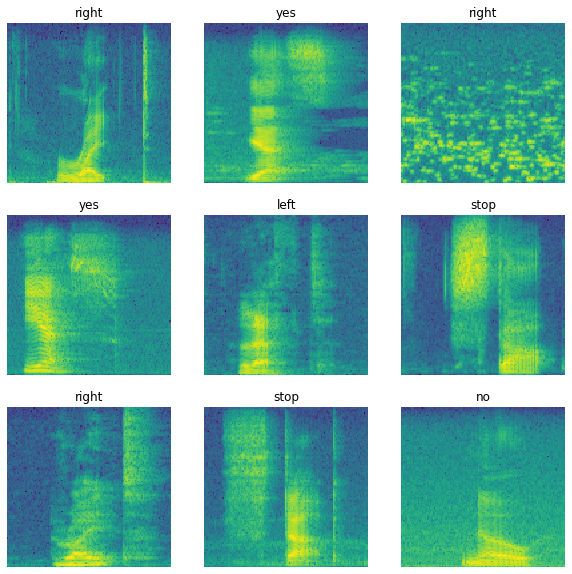

In [15]:
#觀察不同單詞聲音的時頻圖變化
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

In [16]:
#資料前處理
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

In [17]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [18]:
#batch設定
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [19]:
#cache設定
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [20]:
#以時頻資料進行CNN的分類辨識
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = tf.keras.layers.experimental.preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.experimental.preprocessing.Resizing(32, 32), 
    norm_layer,
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_labels),
])

Input shape: (124, 129, 1)


In [21]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [22]:
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=10,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
    #patience允許多少次迭代沒有改善
)

Epoch 1/10
100/100 [==============================] - 47s 179ms/step - loss: 1.9230 - accuracy: 0.2906 - val_loss: 1.2088 - val_accuracy: 0.6000
Epoch 2/10
100/100 [==============================] - 1s 12ms/step - loss: 1.2295 - accuracy: 0.5652 - val_loss: 0.8978 - val_accuracy: 0.7387
Epoch 3/10
100/100 [==============================] - 1s 11ms/step - loss: 0.9184 - accuracy: 0.6772 - val_loss: 0.7474 - val_accuracy: 0.7812
Epoch 4/10
100/100 [==============================] - 1s 11ms/step - loss: 0.7460 - accuracy: 0.7356 - val_loss: 0.6691 - val_accuracy: 0.7862
Epoch 5/10
100/100 [==============================] - 1s 12ms/step - loss: 0.6348 - accuracy: 0.7710 - val_loss: 0.6386 - val_accuracy: 0.7987
Epoch 6/10
100/100 [==============================] - 1s 11ms/step - loss: 0.5682 - accuracy: 0.7913 - val_loss: 0.5881 - val_accuracy: 0.8200
Epoch 7/10
100/100 [==============================] - 1s 12ms/step - loss: 0.4985 - accuracy: 0.8274 - val_loss: 0.5750 - val_accuracy: 0.82

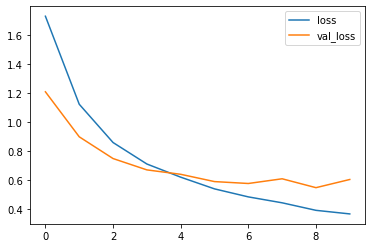

In [23]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

#驗證與測試

In [24]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [25]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 82%


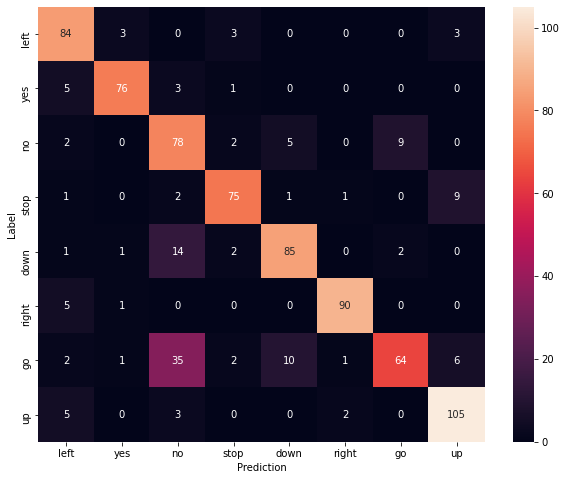

In [26]:
#透過混淆矩陣了解預測情形
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

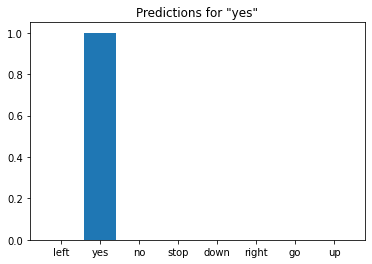

In [27]:
#觀察結果
sample_file = data_dir/'yes/004ae714_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()